**Study of Quantum Field Theory systems via quantum computing techniques**

This respository has the simulation of a $2 \times 2$ lattice for the half filled Fermi-Hubbard model, as a complementary part of the report.

In [2]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 108.4 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [64]:
n_sites = 4  # 2x2 lattice
n_qubits = 2 * n_sites
n_cells = (2, 2)
U = 1
t = 1
layers = 8

In [53]:
dev = qml.device("default.qubit", wires=n_qubits)
qml.drawer.use_style('pennylane')

**On-site interaction term**

The on-site Coulomb interaction for a given site can be written as

\begin{equation}
    e^{- \frac{i}{4} U \theta (1 - Z_i)(1 - Z_j)},
\end{equation}

where $\theta$ is a variational parameter. This term can be implemented using a sequence of three PennyLane operations: two single-qubit $Z$-rotations qml.RZ and one two-qubit Ising interaction gate qml.IsingZZ. The exponential can be expanded as:

\begin{equation}
    e^{- \frac{i}{4} U \theta (1 - Z_i)(1 - Z_j)}
    = e^{- \frac{i U \theta}{4}}
      e^{\frac{i U \theta}{4} Z_i}
      e^{\frac{i U \theta}{4} Z_j}
      e^{-\frac{i U \theta}{4} Z_i Z_j}
\end{equation}

The operators define the sequence of gates used in implementation.

In [65]:
def onsite_interaction(q_i,q_j,theta):
    qml.GlobalPhase(theta / 4)
    qml.RZ( theta / 2, wires=q_i)
    qml.RZ(theta / 2, wires=q_j)
    qml.IsingZZ(theta/ 2, wires=[q_i, q_j])

Hopping term

To implement hopping terms such as

\begin{equation}
    -\frac{J}{2} (X_0 X_4 + Y_0 Y_4) Z_1 Z_2 Z_3,
\end{equation}

where the interaction occurs between non-adjacent qubits, in this case, qubit 0 and qubit 4 in JW ordering, we must eliminate the inefficient Jordan-Wigner $Z$-string $Z_1 Z_2 Z_3$. This is accomplished by moving one qubit to an adjacent position using FSWAP gates.

 Once the qubits are adjacent, we apply a simplified hopping interaction:

\begin{equation}
    e^{- \frac{i J \theta}{4}(X_i X_j + Y_i Y_j)}.
\end{equation}

The movement and interaction can be encoded using the following algorithm:

In [66]:
def apply_hopping(q_i,q_j,theta):
    qml.IsingXY(t * theta, wires=[q_i, q_j])

def move_and_hop(i, j, theta):

    path = list(range(min(i, j), max(i, j)))

    # Mover j hacia i
    for k in path:
        qml.FermionicSWAP(phi=np.pi,wires=[k, k+1])

    # Aplicar hopping entre adyacentes
    apply_hopping(i, i+1, theta)

    # Deshacer swaps
    for k in reversed(path):
        qml.FermionicSWAP(phi=np.pi,wires=[k, k+1])


With all the functions defined we can construct a layer for the Hamiltonian Variational Asantz

In [67]:
def hva_layer(params, layer):
    p = params[layer]


    move_and_hop(0, 3, p[0])
    move_and_hop(0, 4, p[1])
    move_and_hop(1, 2, p[2])
    move_and_hop(1, 5, p[3])
    move_and_hop(3, 7, p[4])
    move_and_hop(2, 6, p[5])
    move_and_hop(4, 7, p[6])
    move_and_hop(5, 6, p[2])

    onsite_interaction(0, 1, p[7])
    onsite_interaction(2, 3, p[7])
    onsite_interaction(4, 5, p[7])
    onsite_interaction(6, 7, p[7])

All what is left is to preapre de initial state, and construct the classical optimizer.

In [57]:
def givens_rotation(i, j, theta, phi=0):
    qml.CNOT(wires=[j, i])
    qml.RZ(phi, wires=j)
    qml.CRY(2 * theta, wires=[i, j])
    qml.CNOT(wires=[j, i])

In [58]:
def prepare_initial_state_givens():
    qml.PauliX(wires=0)
    qml.PauliX(wires=2)

    qml.PauliX(wires=4)
    qml.PauliX(wires=6)

    givens_rotation(0, 1, np.pi / 4)
    givens_rotation(2, 3, np.pi / 4)
    givens_rotation(4, 5, np.pi / 4)
    givens_rotation(6, 7, np.pi / 4)

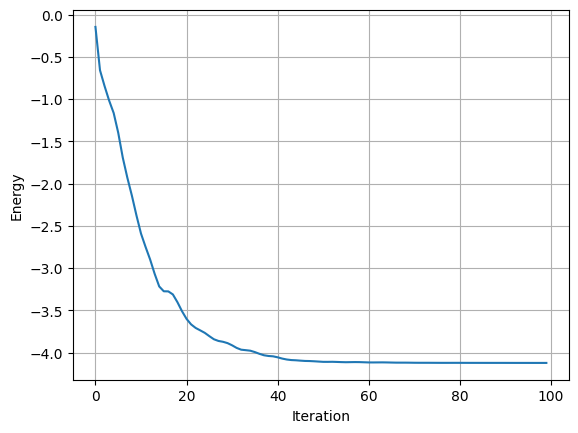

Estimated ground state energy: -4.122366


In [71]:
def prepare_initial_state():
    prepare_initial_state_givens()

# Cost circuit
def circuit(params):
    #prec = 0.1
    #rand_angle = np.pi + prec*np.random.rand() #noise
    #for i in range(n_qubits):
        #qml.RX(rand_angle, wires=i)
    prepare_initial_state()
    for l in range(layers):
        hva_layer(params, l)

@qml.qnode(dev)
def circuit_state(params):
  circuit(params)
  return qml.state()

@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(hamiltonian)

def run_vqe(max_steps=100):
    np.random.seed(42)
    params = np.random.uniform(0, np.pi, size=(layers, 8))
    opt = qml.AdamOptimizer(stepsize=0.1)
    energies = []

    for i in range(max_steps):
        params, energy = opt.step_and_cost(cost_fn, params)
        energies.append(energy)

    plt.plot(energies)
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.grid()
    plt.show()

    #print("\nFinal Optimized Circuit:")
    #fig, ax = qml.draw_mpl(cost_fn)(params)
    #plt.show()

    #print(circuit_state(params))
    return energy



ground_energy = run_vqe()
print(f"Estimated ground state energy: {ground_energy:.6f}")


#### Exact Diagonalization

In [47]:
coeffs_XX_ZZ = [-t/2, -t/2]
ops_XX_ZZ = [qml.PauliX(0) @ qml.PauliX(3) @ qml.PauliZ(1) @ qml.PauliZ(2) , qml.PauliX(4) @ qml.PauliX(7) @ qml.PauliZ(1) @ qml.PauliZ(2)]

coeffs_YY_ZZ = [-t/2, -t/2]
ops_YY_ZZ = [qml.PauliY(0) @ qml.PauliY(3) @ qml.PauliZ(1) @ qml.PauliZ(2) , qml.PauliY(4) @ qml.PauliY(7) @ qml.PauliZ(1) @ qml.PauliZ(2)]

coeffs_XX_ZZZ = [-t/2, -t/2, -t/2, -t/2]
ops_XX_ZZZ = [qml.PauliX(0) @ qml.PauliX(4) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3) ,
              qml.PauliX(3) @ qml.PauliX(7) @ qml.PauliZ(4) @ qml.PauliZ(5) @ qml.PauliZ(6) ,
              qml.PauliX(1) @ qml.PauliX(5) @ qml.PauliZ(2) @ qml.PauliZ(3) @ qml.PauliZ(4) ,
              qml.PauliX(2) @ qml.PauliX(6) @ qml.PauliZ(3) @ qml.PauliZ(4) @ qml.PauliZ(5)]

coeffs_YY_ZZZ = [-t/2, -t/2, -t/2, -t/2]
ops_YY_ZZZ = [qml.PauliY(0) @ qml.PauliY(4) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3) ,
              qml.PauliY(3) @ qml.PauliY(7) @ qml.PauliZ(4) @ qml.PauliZ(5) @ qml.PauliZ(6) ,
              qml.PauliY(1) @ qml.PauliY(5) @ qml.PauliZ(2) @ qml.PauliZ(3) @ qml.PauliZ(4) ,
              qml.PauliY(2) @ qml.PauliY(6) @ qml.PauliZ(3) @ qml.PauliZ(4) @ qml.PauliZ(5)]

coeffs_XX = [-t/2, -t/2]
ops_XX = [qml.PauliX(1) @ qml.PauliX(2) , qml.PauliX(5) @ qml.PauliX(6)]

coeffs_YY = [-t/2, -t/2]
ops_YY = [qml.PauliY(1) @ qml.PauliY(2) , qml.PauliY(5) @ qml.PauliY(6)]

hamiltonian_hopp = qml.Hamiltonian(coeffs_XX_ZZ, ops_XX_ZZ) + qml.Hamiltonian(coeffs_YY_ZZ, ops_YY_ZZ) + qml.Hamiltonian(coeffs_XX_ZZZ, ops_XX_ZZZ) + qml.Hamiltonian(coeffs_YY_ZZZ, ops_YY_ZZZ) + qml.Hamiltonian(coeffs_XX, ops_XX) + qml.Hamiltonian(coeffs_YY, ops_YY)

In [48]:
coeffs_Z = [-U/4, -U/4, -U/4, -U/4, -U/4, -U/4, -U/4, -U/4]
ops_Z = [qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(3), qml.PauliZ(4), qml.PauliZ(5), qml.PauliZ(6), qml.PauliZ(7)]

coeffs_ZZ = [U/4, U/4, U/4, U/4]
ops_ZZ = [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliZ(2) @ qml.PauliZ(3), qml.PauliZ(4) @ qml.PauliZ(5), qml.PauliZ(6) @ qml.PauliZ(7)]

hamiltonian_onsite = qml.Hamiltonian(coeffs_Z, ops_Z) + qml.Hamiltonian(coeffs_ZZ, ops_ZZ)

In [49]:
hamiltonian = hamiltonian_hopp + hamiltonian_onsite

hamiltonian_mat = qml.matrix(hamiltonian, wire_order=[0, 1, 2, 3, 4, 5, 6, 7])

In [38]:
from numpy import linalg as LA
from scipy.linalg import expm, sinm, cosm
import matplotlib.pyplot as plt
from functools import reduce

In [50]:
eigenvalues, eigenvectors = LA.eigh(hamiltonian_mat)
eigenvalues + U#valor del offset de U



array([-4.37228132e+00, -3.55405387e+00, -3.55405387e+00, -3.37228132e+00,
       -3.34084762e+00, -3.29295138e+00, -3.21111226e+00, -3.21111226e+00,
       -2.86387634e+00, -2.78526086e+00, -2.72359564e+00, -2.72359564e+00,
       -2.72359564e+00, -2.72359564e+00, -2.55405387e+00, -2.55405387e+00,
       -2.45136862e+00, -2.45136862e+00, -2.00000000e+00, -2.00000000e+00,
       -2.00000000e+00, -2.00000000e+00, -2.00000000e+00, -2.00000000e+00,
       -2.00000000e+00, -2.00000000e+00, -2.00000000e+00, -1.79128785e+00,
       -1.79128785e+00, -1.61803399e+00, -1.61803399e+00, -1.56155281e+00,
       -1.56155281e+00, -1.50972115e+00, -1.50972115e+00, -1.45136862e+00,
       -1.45136862e+00, -1.30277564e+00, -1.30277564e+00, -1.25806217e+00,
       -1.25806217e+00, -1.21111226e+00, -1.21111226e+00, -1.17371582e+00,
       -1.17371582e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -